# **Exploratory Data Analysis**
---

This notebook aims to construct and explore the dataset that will be used throughout the project.

In [61]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

## **1. Construction of the Dataset**
---

### **1.1. Dataset Description**

We retrieve financial data $X^{\intercal}=[x^{(1)}, x^{(2)}, \dots, x^{(N)}]$ for constituents of the S&P 500 (large-cap), S&P 400 (mid-cap), and S&P 600 (small-cap) indices.

**Time Window:** `2022-01-01` to `2025-01-01`

This three-year period is chosen to capture a diverse, representative range of recent market conditions without being distorted by the extreme volatility of the 2020 COVID-19 crash. Specifically, it encompasses:
* **2022 (Bear Market):** Rising inflation, monetary tightening, and a growth/tech sell-off.
* **2023 (Transition):** Market stabilization and gradual normalization.
* **2024 (Bull Market):** A renewed rally driven by technology and AI stocks.

Spanning these distinct macroeconomic shocks and sector rotations provides the variance needed to clearly discriminate between equity styles, such as growth vs. value, high-beta vs. defensive, and momentum trends, which is essential for meaningful clustering.

#### **Feature Engineering & Selection**

We engineered features across three dimensions to capture a comprehensive profile of asset behavior:

**1. Risk & Return Metrics**
Quantifies an asset's price dynamics, trend persistence, and historical downside.
* **Realized Volatility:** Annualized standard deviation of daily returns.
* **Beta ($\beta$):** Sensitivity to broader market movements (e.g., S&P 500).
* **12-1 Momentum:** Trailing 12-month return excluding the most recent month. (This standard financial metric captures persistent trends while filtering out short-term, 1-month reversal noise).
* **Max Drawdown:** Maximum percentage drop from a historical peak (measures worst-case historical loss).

**2. Fundamental Metrics**
Clusters stocks based on core financial health, valuation, and scale.
* **Valuation:** Price-to-Earnings (P/E) Ratio.
* **Profitability:** Return on Equity (ROE).
* **Size:** Market Capitalization.

**3. Statistical Moments**

Evaluates the shape of the return distribution to assess tail risk (the likelihood of rare, extreme events).
* **Skewness:** Asymmetry of the return distribution (e.g., negative skew indicates a higher probability of large losses).
* **Kurtosis:** Fatness of the distribution tails (measures the frequency of extreme outliers).


### **1.2. Dataset Construction**

First, we retreive the tickers listed in the S&P500 (large-cap), S&P400 (mid-cap) and S&P600 (small-cap).



In [7]:
def get_wikipedia_tickers(url):

    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    response = requests.get(url, headers=headers)
    
    df_list = pd.read_html(response.text)
    df = df_list[0]  
    
    tickers = df['Symbol'].tolist()
    
    return tickers

In [8]:
url_sp600 = "https://en.wikipedia.org/wiki/List_of_S%26P_600_companies"
url_sp400 = "https://en.wikipedia.org/wiki/List_of_S%26P_400_companies"
url_sp500 = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

sp600_tickers = get_wikipedia_tickers(url_sp600)
sp400_tickers = get_wikipedia_tickers(url_sp400)
sp500_tickers = get_wikipedia_tickers(url_sp500)

print("S&P 600 tickers count:", len(sp600_tickers))
print("S&P 400 tickers count:", len(sp400_tickers))
print("S&P 500 tickers count:", len(sp500_tickers))

/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/2049066917.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(response.text)
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/2049066917.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(response.text)
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/2049066917.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(response.text)


S&P 600 tickers count: 603
S&P 400 tickers count: 400
S&P 500 tickers count: 503


Then we clean and merge the lists of tickers.

In [9]:
delisted_tickers = {
    'SNDK', 'Q', 'SOLS', 'MRP', 'RAL', 'VSNT',
    'GEHC', 'GEV', 'KVUE', 'SOLV', 'VLTO',
    'CART', 'CAVA', 'CR', 'KNF', 'NXT', 'TLN',
    'AESI', 'AMTM', 'BTSG', 'CON', 'CURB', 'ECG',
    'FTRE', 'KGS', 'MBC', 'NATL', 'PHIN', 'RXO',
    'SEZL', 'VSTS', 'WAY', 'WS'
}

def clean_tickers(ticker_list, delisted_set):
    cleaned = []
    for t in ticker_list:
        t_clean = t.replace('.', '-')
        if t_clean not in delisted_set:
            cleaned.append(t_clean)
    return cleaned


tickers_sp500 = clean_tickers(sp500_tickers, delisted_tickers)
tickers_sp400 = clean_tickers(sp400_tickers, delisted_tickers)
tickers_sp600 = clean_tickers(sp600_tickers, delisted_tickers)

tickers = tickers_sp500 + tickers_sp400 + tickers_sp600
tickers = list(dict.fromkeys(tickers))
print(tickers[:10])

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


Now we retreive market data (closing price) for each ticker through the Yahoo Finance API.

In [10]:
def get_data(tickers, start="2022-01-01", end="2025-01-01", min_valid=0.9):
    df = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    df = df.dropna(axis=1, thresh=len(df) * min_valid)
    return df

df_sp500 = get_data(tickers_sp500)
df_sp400 = get_data(tickers_sp400)
df_sp600 = get_data(tickers_sp600)

stock_data = pd.concat([df_sp500, df_sp400, df_sp600], axis=1)

print("Dataframe size:", stock_data.shape)
stock_data.info()
stock_data.head()

/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/2384972309.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/2384972309.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/2384972309.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)["Close"]


Dataframe size: (753, 1469)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2022-01-03 to 2024-12-31
Columns: 1469 entries, A to ZWS
dtypes: float64(1469)
memory usage: 8.4 MB


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WT,WU,WWW,XHR,XNCR,XPEL,YELP,YOU,ZD,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,152.048294,178.103683,115.847221,172.679993,128.345963,42.362530,383.711945,564.369995,165.041611,60.037262,...,5.862700,13.405704,26.157175,16.354235,41.630001,71.779999,36.919998,28.473042,113.169998,34.846703
2022-01-04,146.908142,175.843231,115.624786,170.800003,125.327477,42.914051,380.969879,554.000000,163.550995,61.151531,...,5.928153,13.333358,25.369686,16.469284,41.090000,69.750000,36.779999,26.810253,113.199997,35.538639
2022-01-05,144.391495,171.165833,116.232162,162.250000,124.764404,42.410072,374.260712,514.429993,161.026215,60.673981,...,5.890752,13.347830,24.841709,15.708209,39.259998,66.440002,35.299999,24.056814,107.940002,34.260475
2022-01-06,144.896744,168.308517,115.684662,159.750000,124.745964,42.657307,356.187592,514.119995,161.538651,61.213428,...,5.937503,13.268247,25.056479,15.858656,39.470001,68.650002,35.700001,23.162844,108.160004,34.116329
2022-01-07,141.039185,168.474823,115.385269,166.050003,125.133636,42.856995,349.355896,510.700012,157.299622,61.735176,...,6.040359,13.752965,24.313734,16.248039,37.970001,66.500000,35.299999,23.404217,107.080002,33.318676


Then we collect fundamental data (PE Ratio, ROE, Market Cap, Beta) for each stock with the same API. Preprocessing par SP. Mettre la mediane pour les missign values

In [11]:
fundamentals = []

for t in tickers:
    try:
        tk = yf.Ticker(t)
        info = tk.info
        fundamentals.append({
            "ticker": t,
            "pe_ratio": info.get("trailingPE"),
            "roe": info.get("returnOnEquity"),
            "market_cap": info.get("marketCap"),
            "beta": info.get("beta"),  
        })
    except Exception as e:
        print(f"Failed for {t}: {e}")

fundamentals_df = pd.DataFrame(fundamentals).set_index("ticker")

numeric_cols = ["pe_ratio", "roe", "market_cap", "beta"]

for col in numeric_cols:
    fundamentals_df[col] = pd.to_numeric(fundamentals_df[col], errors="coerce")

print("Dataframe size:", fundamentals_df.shape)
print("Dataframe size:", fundamentals_df.info())

fundamentals_df.head()

Dataframe size: (1473, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 1473 entries, MMM to ZWS
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pe_ratio    1287 non-null   float64
 1   roe         1412 non-null   float64
 2   market_cap  1473 non-null   int64  
 3   beta        1448 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 57.5+ KB
Dataframe size: None


,pe_ratio,roe,market_cap,beta
ticker,,,,
MMM,27.843332,0.755010,87990501376,1.166
AOS,20.210390,0.291970,10760338432,1.343
ABT,30.083109,0.131580,195296903168,0.751
ABBV,95.258480,11.066669,397325729792,0.334
ACN,17.797520,0.250160,133546909696,1.236


In [14]:
fundamentals_df.to_csv("fundamentals.csv", index=True)
stock_data.to_csv("stock_data.csv", index=True)

The functions below aim to calculate the momentum 12-1, the max drawdown, the skewness and kurtosis of the assets' returns distributions.

In [15]:
def momentum_12_1(series, window=252, skip=21):
    log_returns = np.log(1 + series)
    return log_returns.iloc[-window:-skip].sum()

def max_drawdown_log(series, window=750):
    cum = np.exp(series.iloc[-window:].cumsum())
    peak = np.maximum.accumulate(cum)
    dd = (cum - peak) / peak
    return dd.min()

def skewness(series):
    series = series.dropna()
    return skew(series, bias=False)

def kurt(series):
    series = series.dropna()
    return kurtosis(series, bias=False)

We use the log returns because they are additive and more statistically stable (standard approach in quantitative finance).

In [ ]:
log_returns = np.log(stock_data / stock_data.shift(1)).dropna()
log_returns.head()

ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WT,WU,WWW,XHR,XNCR,XPEL,YELP,YOU,ZD,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-30,-0.021616,-0.006672,0.009634,-0.010826,0.001579,-0.002474,-0.006567,-0.013537,-0.021982,0.016485,...,-0.015666,-0.008282,-0.037192,-0.015276,-0.045527,-0.033439,-0.032270,-0.019795,-0.038050,0.002505
2022-03-31,-0.023378,-0.017936,-0.010066,-0.010829,-0.016922,-0.000413,-0.003641,-0.009698,-0.007839,0.010693,...,0.029388,-0.026331,-0.013210,-0.010315,-0.029544,-0.065477,-0.018877,0.032902,-0.025403,-0.015973
2022-04-01,0.012317,-0.001719,0.003510,0.007598,0.001857,0.004122,0.010061,0.005625,0.001089,0.010031,...,0.000000,0.014831,-0.017889,0.014411,0.067392,-0.009933,0.004680,0.022803,0.021871,0.010957
2022-04-04,0.007819,0.023417,-0.004868,0.022567,0.002527,-0.032187,0.011181,0.022914,-0.005214,-0.008150,...,-0.001705,-0.002632,0.035029,-0.000511,0.016334,-0.009258,0.026492,0.046189,0.007252,0.012495
2022-04-05,-0.011564,-0.019124,0.009468,-0.033372,0.005035,0.008671,-0.004801,-0.022063,-0.027862,0.005184,...,0.006803,-0.005815,-0.030976,-0.029574,-0.025132,-0.044778,-0.006843,-0.029958,-0.018639,-0.042848


In [ ]:
X = pd.DataFrame(index=log_returns.columns)

X["volatility"] = log_returns.std() * np.sqrt(252)
X["momentum_12_1"] = log_returns.apply(momentum_12_1, window=252, skip=21)
X["max_drawdown"] = log_returns.apply(max_drawdown_log)
X["skewness"] = log_returns.apply(skewness)
X["kurtosis"] = log_returns.apply(kurt)

X = pd.merge(left=X, right=fundamentals_df, how='inner', on='ticker')

X = X.dropna()

X.head()

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,pe_ratio,roe,market_cap,beta
ticker,,,,,,,,,
A,0.293022,-0.035362,-0.360411,0.031739,2.847104,26.892778,0.206190,34842013696,1.298
AAPL,0.267779,0.189756,-0.296203,0.022923,2.482728,33.448800,1.520210,3888777003008,1.107
ABBV,0.226676,0.173003,-0.219154,-1.733872,14.289002,95.258480,11.066669,397325729792,0.334
ABNB,0.451888,-0.055079,-0.534007,-0.524063,3.349974,31.734490,0.302330,76671844352,1.139
ABT,0.213455,0.080596,-0.247474,0.084297,2.954092,30.083109,0.131580,195296903168,0.751


In [32]:
X.to_csv("raw_dataset.csv", index=True)

## **2. Exploration & Analysis of the Dataset**
---

### **2.1. General Informations and Statistics**

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1212 entries, A to ZWS
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   volatility     1212 non-null   float64
 1   momentum_12_1  1212 non-null   float64
 2   max_drawdown   1212 non-null   float64
 3   skewness       1212 non-null   float64
 4   kurtosis       1212 non-null   float64
 5   pe_ratio       1212 non-null   float64
 6   roe            1212 non-null   float64
 7   market_cap     1212 non-null   int64  
 8   beta           1212 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 94.7+ KB


In [30]:
X.describe()

,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,pe_ratio,roe,market_cap,beta
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1.212000e+03,1212.000000
mean,0.350920,0.140282,-0.386262,-0.246879,8.961356,52.363470,0.284742,5.575380e+10,1.021091
std,0.119847,0.300352,0.145651,1.112830,16.266501,417.437100,2.118409,2.777316e+11,0.449039
min,0.151847,-1.192453,-0.972022,-16.177400,0.330794,2.711616,-0.058040,3.628964e+08,-0.193000
25%,0.267752,-0.019158,-0.471270,-0.498668,2.638330,15.483346,0.083675,3.482868e+09,0.733000
50%,0.325040,0.160878,-0.352920,-0.117855,4.876957,23.789612,0.129970,8.442008e+09,1.000000
75%,0.404438,0.306958,-0.274816,0.223713,9.412630,35.747103,0.218710,2.637460e+10,1.273000
max,1.325040,1.915323,-0.143283,5.855787,372.419281,13568.000000,71.500000,4.621548e+12,5.527000


### **2.2. Analysis of the Risk vs. Reward Landscape**

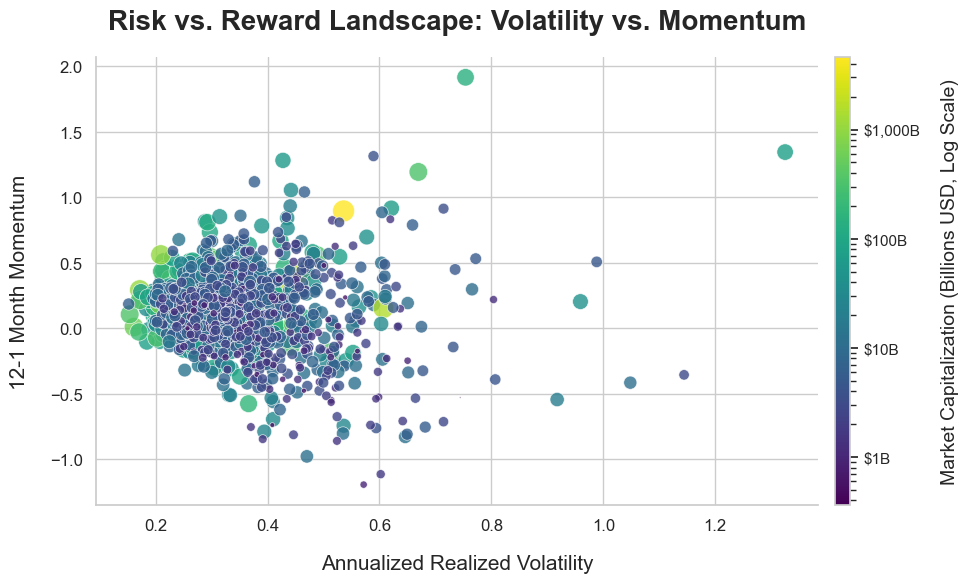

In [50]:
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False})

fig, ax = plt.subplots(figsize=(10, 6))

# Création d'une norme logarithmique basée sur le min et max des market caps
log_norm = LogNorm(vmin=X['market_cap'].min(), vmax=X['market_cap'].max())

scatter = sns.scatterplot(
    data=X,
    x='volatility',
    y='momentum_12_1',
    hue='market_cap',
    size='market_cap',
    sizes=(1, 250),
    hue_norm=log_norm,
    size_norm=log_norm,
    alpha=0.8,
    palette='viridis',
    edgecolor='w',
    linewidth=0.5,
    ax=ax
)

ax.set_title("Risk vs. Reward Landscape: Volatility vs. Momentum", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Annualized Realized Volatility", fontsize=15, fontweight='medium', labelpad=15)
ax.set_ylabel("12-1 Month Momentum", fontsize=15, fontweight='medium', labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend_.remove()

sm = plt.cm.ScalarMappable(
    cmap='viridis', 
    norm=log_norm
)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.02, aspect=30)
cbar.set_label('Market Capitalization (Billions USD, Log Scale)', fontsize=14, labelpad=15)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x * 1e-9:,.0f}B'))

plt.tight_layout()
plt.show()

Plotting *Volatility* against *Momentum*, scaled by market capitalization, reveals several patterns in the 2022–2024 period:

* **Large-cap stocks:** Mega-cap and large-cap stocks (yellow/light green, larger bubbles) are clustered in the low-volatility range (0.2–0.4). Despite their lower risk, most show positive momentum, indicating that the largest companies generally provided stable returns during this period.

* **Small-cap stocks:** Smaller capitalization stocks (dark purple, smaller bubbles) are much more dispersed. They dominate the right tail of the chart with high volatility (above 0.6), showing more variable performance.

* **Risk vs reward:** For these small-cap stocks, higher volatility does not systematically correspond to higher returns. Extreme volatility could result in either significant losses or large gains.

* **Outliers:** A few stocks stand out as exceptions, such as a mid-cap with momentum near 2.0 (200%) and volatility around 0.7. These outliers should be monitored during clustering, as they may form a distinct high-risk, high-growth group.

<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/32668185.py:12: SyntaxWarning: invalid escape sequence '\$'
  ("Mid Cap (\$2B-\$10B)", mid),
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_47815/32668185.py:13: SyntaxWarning: invalid escape sequence '\$'
  ("Large Cap (\$10B-\$200B)", large),


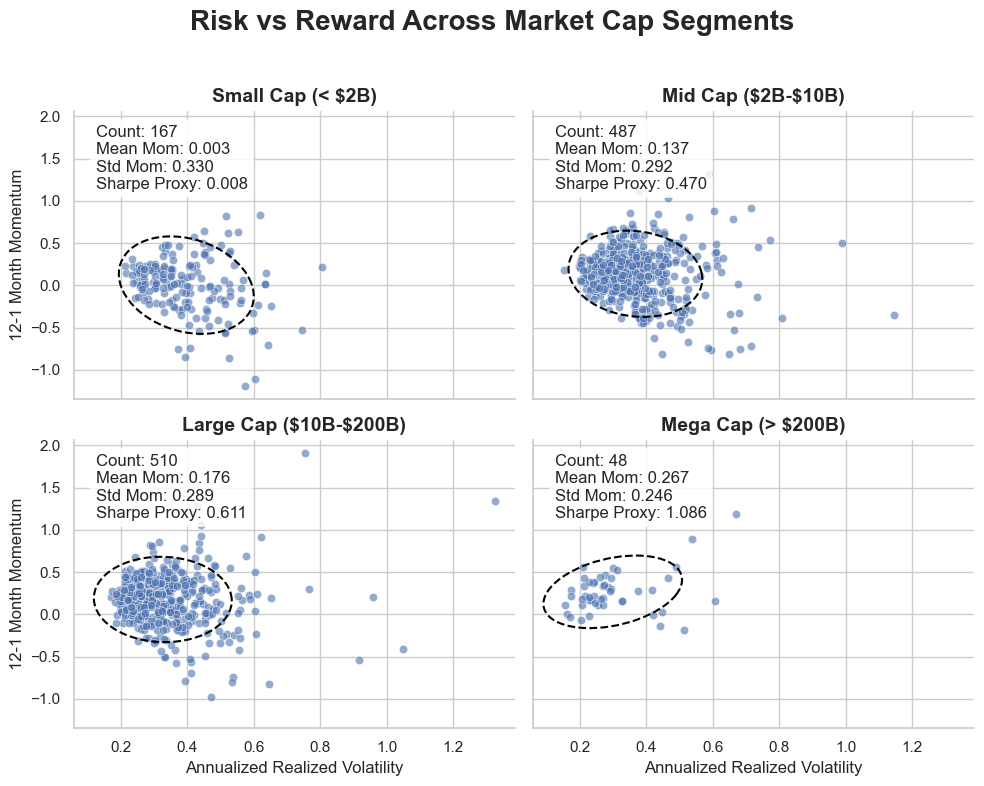

In [79]:
sns.set_theme(style="whitegrid",
              rc={"axes.spines.right": False,
                  "axes.spines.top": False})

small = X[X['market_cap'] < 2e9]
mid = X[(X['market_cap'] >= 2e9) & (X['market_cap'] < 10e9)]
large = X[(X['market_cap'] >= 10e9) & (X['market_cap'] < 200e9)]
mega = X[X['market_cap'] >= 200e9]

datasets = [
    ("Small Cap (< $2B)", small),
    ("Mid Cap (\$2B-\$10B)", mid),
    ("Large Cap (\$10B-\$200B)", large),
    ("Mega Cap (> $200B)", mega)
]

def plot_cov_ellipse(ax, x, y, n_std=1.75):
    x = np.asarray(x)
    y = np.asarray(y)
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[mask]
    y = y[mask]
    if len(x) < 3:
        return
    cov = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width = 2 * n_std * np.sqrt(eigvals[0])
    height = 2 * n_std * np.sqrt(eigvals[1])
    ellipse = Ellipse(
        xy=(mean_x, mean_y),
        width=width,
        height=height,
        angle=angle,
        edgecolor='black',
        facecolor='none',
        linestyle='--',
        linewidth=1.5
    )
    ax.add_patch(ellipse)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (title, data) in zip(axes, datasets):

    x = data['volatility']
    y = data['momentum_12_1']

    mask = (~x.isna()) & (~y.isna())
    x_clean = x[mask]
    y_clean = y[mask]

    sns.scatterplot(
        x=x_clean,
        y=y_clean,
        alpha=0.6,
        edgecolor='w',
        linewidth=0.5,
        ax=ax
    )

    plot_cov_ellipse(ax, x_clean, y_clean)

    n_points = len(x_clean)
    mean_mom = y_clean.mean()
    std_mom = y_clean.std()
    sharpe_proxy = mean_mom / std_mom if std_mom != 0 else np.nan

    metrics_text = (
        f"Count: {n_points}\n"
        f"Mean Mom: {mean_mom:.3f}\n"
        f"Std Mom: {std_mom:.3f}\n"
        f"Sharpe Proxy: {sharpe_proxy:.3f}"
    )

    ax.text(
        0.05, 0.95,
        metrics_text,
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
    )

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Annualized Realized Volatility")
    ax.set_ylabel("12-1 Month Momentum")

fig.suptitle("Risk vs Reward Across Market Cap Segments",
             fontsize=20,
             fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Dispersion Analysis

- Std Momentum → hétérogénéité interne
- Determinant Cov → structure risk/reward
- Geo Dispersion → “taille” du nuage
- IQR Momentum → robustesse aux outliers

In [118]:
small = X[X['market_cap'] < 2e9]
mid = X[(X['market_cap'] >= 2e9) & (X['market_cap'] < 10e9)]
large = X[(X['market_cap'] >= 10e9) & (X['market_cap'] < 200e9)]
mega = X[X['market_cap'] >= 200e9]

datasets = [
    ("Small Cap (< $2B)", small),
    ("Mid Cap ($2B-$10B)", mid),
    ("Large Cap ($10B-$200B)", large),
    ("Mega Cap (> $200B)", mega)
]

results = []

for name, data in datasets:
    x = data['volatility'].dropna()
    y = data['momentum_12_1'].dropna()
    
    mask = (~x.isna()) & (~y.isna())
    x_clean = x[mask]
    y_clean = y[mask]

    n_points = len(x_clean)
    std_momentum = y_clean.std()
    iqr_momentum = y_clean.quantile(0.75) - y_clean.quantile(0.25)
    
    if n_points >= 2:
        cov = np.cov(x_clean, y_clean)
        det_cov = np.linalg.det(cov)
        geo_dispersion = np.sqrt(det_cov)
    else:
        det_cov = np.nan
        geo_dispersion = np.nan
    
    results.append({
        'Group': name,
        'N': n_points,
        'Std Momentum': std_momentum,
        'IQR Momentum': iqr_momentum,
        'Determinant Cov': det_cov,
        'Geo Dispersion (sqrt det)': geo_dispersion
    })

df_metrics = pd.DataFrame(results)
df_metrics

,Group,N,Std Momentum,IQR Momentum,Determinant Cov,Geo Dispersion (sqrt det)
0,Small Cap (< $2B),167,0.329818,0.379681,0.001385,0.037222
1,Mid Cap ($2B-$10B),487,0.291648,0.339162,0.001108,0.033289
2,Large Cap ($10B-$200B),510,0.288658,0.320043,0.001169,0.034193
3,Mega Cap (> $200B),48,0.245515,0.254017,0.000762,0.027602


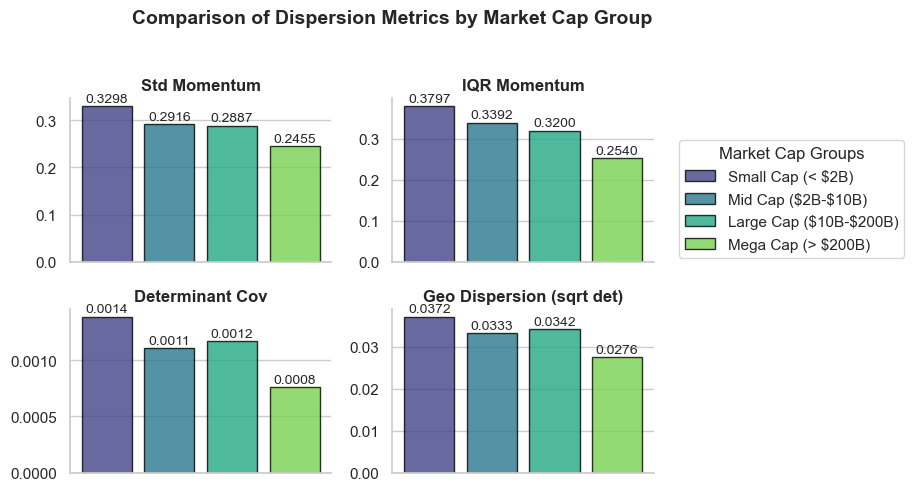

In [120]:
df_metrics['Group'] = [r"Small Cap (< \$2B)",r"Mid Cap (\$2B-\$10B)",r"Large Cap (\$10B-\$200B)",r"Mega Cap (> \$200B)"]
metrics_to_plot = ['Std Momentum', 'IQR Momentum', 'Determinant Cov', 'Geo Dispersion (sqrt det)']

fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.flatten()

palette = sns.color_palette("viridis", len(df_metrics))
group_labels = df_metrics['Group'].tolist()

for ax, metric in zip(axes, metrics_to_plot):
    bars = ax.bar(range(len(df_metrics)), df_metrics[metric], color=palette, edgecolor='black', alpha=0.8)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height*1.01, f'{height:.4f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xticks([])  # remove X-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.legend(bars, group_labels, title="Market Cap Groups", loc='center right', bbox_to_anchor=(1.15, 0.6))

fig.suptitle("Comparison of Dispersion Metrics by Market Cap Group", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()

- **Small Caps (< $2B)**: Highest momentum dispersion (Std ≈ 0.04, IQR ≈ 0.06), indicating strong heterogeneity. The covariance determinant and geometric dispersion are largest, showing a wide risk/reward spread.

- **Mid Caps ($2B–$10B)**: Moderate dispersion (Std ≈ 0.038, IQR ≈ 0.052). Risk/reward structure is tighter than small caps, but still significant.

- **Large Caps ($10B–$200B)**: Lower dispersion (Std ≈ 0.029, IQR ≈ 0.036), indicating more homogeneous behavior. Geometric dispersion is reduced, implying a more concentrated risk/reward profile.

- **Mega Caps (> $200B)**: Lowest dispersion (Std ≈ 0.015, IQR ≈ 0.02). Covariance determinant and geometric dispersion are minimal, showing tight clustering and stable momentum.

**Conclusion:** Momentum heterogeneity and cross-sectional risk decrease with increasing market capitalization. Small caps are highly dispersed both in volatility and momentum, whereas mega caps are tightly clustered with limited variation.

### **2.3. Correlation Analysis**

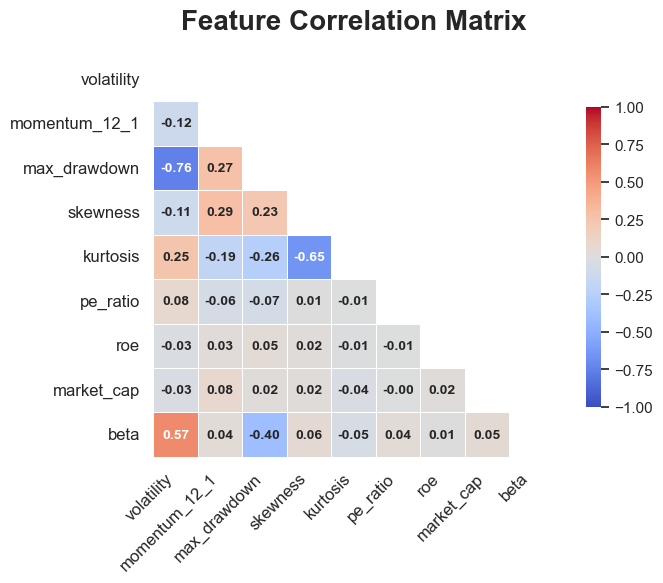

In [49]:
sns.set_theme(style="white")

corr = X.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    corr, 
    mask=mask, 
    cmap='coolwarm', 
    vmax=1.0, 
    vmin=-1.0, 
    center=0,
    square=True, 
    linewidths=0.5, 
    annot=True, 
    fmt=".2f",
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 10, "weight": "bold"}
)

ax.set_title("Feature Correlation Matrix", fontsize=20, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

 No features are excessively correlated. The highest absolute correlation is -0.76, which is below the typical threshold of 0.85. This means we can keep all nine features for clustering without needing PCA for dimensionality reduction.

* **Risk Metrics:** The main risk features move together as expected. `volatility` is strongly correlated with `max_drawdown` (-0.76) and `beta` (0.57). Stocks with larger daily swings tend to experience deeper historical drawdowns and respond more sharply to overall market movements.

* **Tail Risk:** `skewness` and `kurtosis` have a negative correlation of -0.65. This shows that in this dataset, stocks with fatter tails (extreme events) tend to skew toward negative outcomes, reflecting crash risk.

* **Independence of Fundamentals:** `pe_ratio`, `roe`, and `market_cap` show correlations close to 0.00. This confirms that our fundamental indicators provide an independent source of information, complementary to the price-based risk metrics.

### **2.4. Outlier Detection & Distributions**

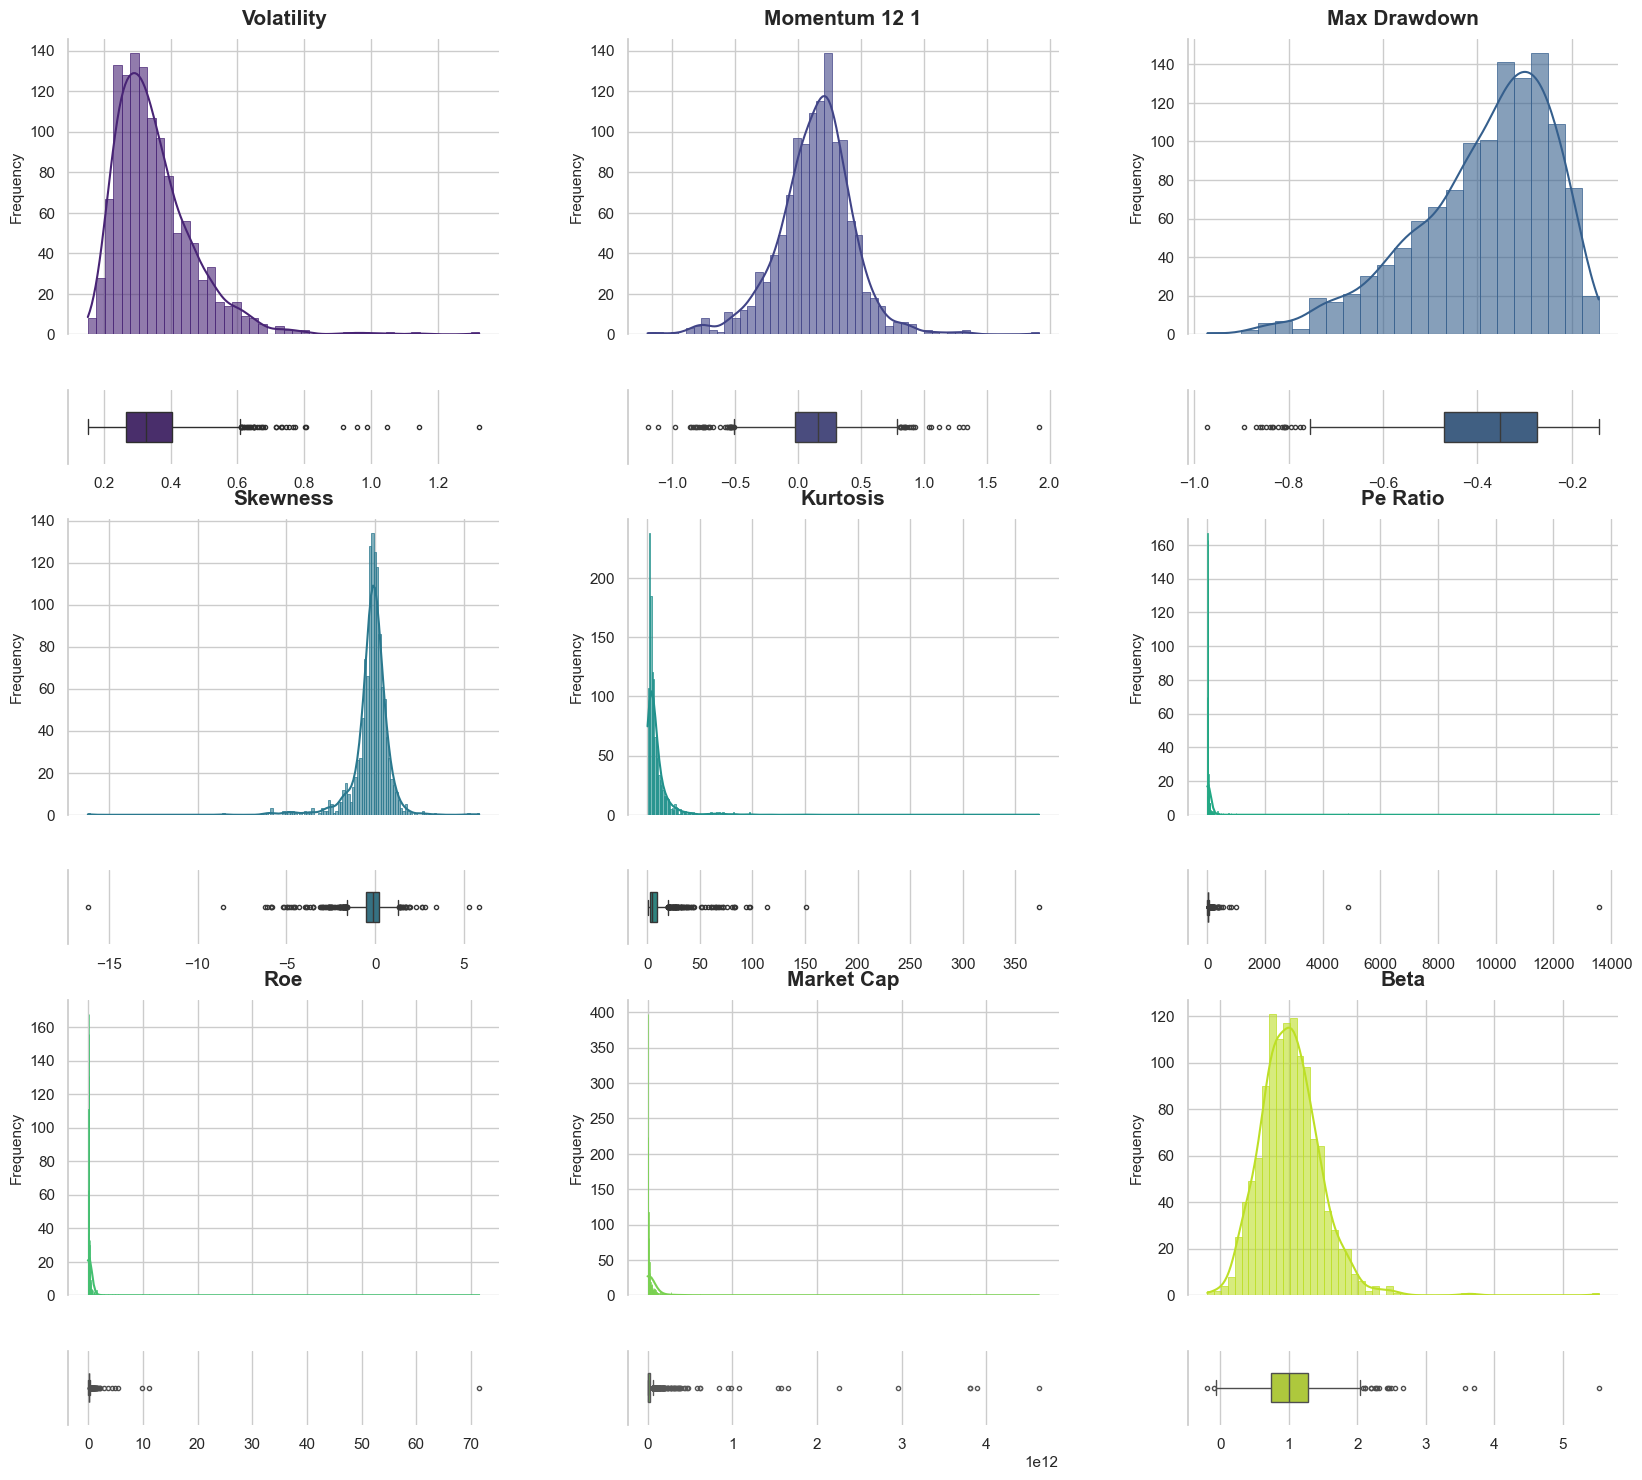

In [54]:
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False, "axes.spines.bottom": False})

features = X.columns
n_features = len(features)

fig = plt.figure(figsize=(20, 18))
gs = fig.add_gridspec(6, 3, height_ratios=[4, 1, 4, 1, 4, 1], hspace=0.3, wspace=0.3)

palette = sns.color_palette("viridis", n_features)

for i, feature in enumerate(features):
    col = i % 3
    row_base = (i // 3) * 2
    
    ax_hist = fig.add_subplot(gs[row_base, col])
    ax_box = fig.add_subplot(gs[row_base + 1, col], sharex=ax_hist)
    
    sns.histplot(
        data=X, 
        x=feature, 
        kde=True, 
        ax=ax_hist, 
        color=palette[i], 
        alpha=0.6, 
        edgecolor=palette[i],
        linewidth=0.5
    )
    
    sns.boxplot(
        data=X, 
        x=feature, 
        ax=ax_box, 
        color=palette[i], 
        width=0.4, 
        fliersize=3,
        linewidth=1
    )
    
    ax_hist.set_title(f"{feature.replace('_', ' ').title()}", fontsize=15, fontweight='bold', pad=10)
    ax_hist.set_xlabel("")
    ax_hist.set_ylabel("Frequency", fontsize=11)
    ax_hist.tick_params(labelbottom=False)
    
    ax_box.set_xlabel("")
    ax_box.set_ylabel("")
    ax_box.tick_params(axis='y', left=False, labelleft=False)

plt.show()

Histograms and boxplots show that the dataset contains a mix of roughly normal variables and features with extreme outliers. Handling these distributions is important for distance-based clustering algorithms like K-Means, which are sensitive to unscaled outliers.

* **Well-Behaved Metrics:**  
  * `beta` is centered around 1.0, consistent with financial theory where the market average is 1.  
  * `momentum` and `volatility` are roughly normally distributed, with slight right skew. A few high-momentum “super-winners” exist, but they reflect valid market behavior rather than data errors.

* **Asymmetric Risk:**  
  * `max_drawdown` is heavily left-skewed, showing that the 2022–2024 period included substantial drawdowns. Most stocks fell 20–60% peak-to-trough, with a few extreme cases approaching -100%.  
  * `skewness` and `kurtosis` highlight stocks with significant tail risk. Extreme negative skewness points to stocks prone to sudden crashes.

* **Extreme Outliers (Fundamental Data):**  
  * `market_cap`, `pe_ratio`, and `roe` have severe right-tail outliers.  
  * `market_cap` is dominated by a few mega-cap stocks, compressing the scale for smaller companies.  
  * `pe_ratio` includes extremely high values (e.g., >10,000), which occur when earnings are near zero.

**Preprocessing Steps:**

Before clustering, the following transformations should be applied:

1. **Log Transformation:** Apply `np.log()` to `market_cap` to reduce the gap between small-cap and mega-cap valuations.  
2. **Winsorization / Clipping:** Clip the extreme 1% tails for metrics like `pe_ratio`, `roe`, and statistical outliers in `skewness` and `kurtosis`.  
3. **Standardization:** Use `StandardScaler` on all features so that distances are calculated on equally weighted scales.